In [1]:
import sys
sys.path.append('/Users/celiaberon/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/celiaberon/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as scio
import bandit_preprocessing as bp
import sys
import os
import matplotlib.pyplot as plt
import calcium_codes as cc
import hmm_on_behavior as hob
%matplotlib inline

In [67]:
record_path = '/Users/celiaberon/GitHub/mouse_bandit/session_record.csv'
ca_data_path = '/Volumes/Neurobio/MICROSCOPE/Celia/data/k7_03142017_test/neuron_results.mat'
#ca_data_path = '/Volumes/Neurobio/MICROSCOPE/Celia/data/q43_03202017_bandit_8020/q43_03202017_neuron_master.mat'
#ca_data_path = '/Volumes/Neurobio/MICROSCOPE/Celia/data/cnmfe_test/neuron_results.mat'

record = pd.read_csv(record_path,index_col=0)
ca_data = scio.loadmat(ca_data_path,squeeze_me = True, struct_as_record = False)
neuron = ca_data['neuron_results'] 

In [68]:
neuron.C_raw.shape

(97, 57600)

In [69]:
session_name  = '03142017_K7'
mouse_id = 'K7'

#session_name = '03202017_Q43'
#mouse_id = 'Q43'

record[record['Session ID'] == session_name]

,Session ID,Mouse ID,Date,Phase,Left Reward Prob,Right Reward Prob,Block Range Min,Block Range Max,No. Trials,No. Blocks,No. Rewards,p(high Port),Decision Window Duration,Min Inter-trial-interval,Left Solenoid Duration,Right Solenoid Duration
676,03142017_K7,K7,2017-03-14 00:00:00,2.0,0.8,0.2,50.0,50.0,519.0,7.0,378.0,0.89,2.0,1.0,35.0,35.0


# Extract data from specific session

In [70]:
'''
load in trial data
'''
columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
           'Right Reward Prob','Left Reward Prob','Reward Given',
          'center_frame','decision_frame']

root_dir = '/Users/celiaberon/GitHub/mouse_bandit/data/trial_data'

full_name = session_name + '_trials.csv'

path_name = os.path.join(root_dir,full_name)

trial_df = pd.read_csv(path_name,names=columns)

### Add column for estimated by HMM using entire session as memory

In [71]:
beliefs = hob.predictBeliefBySession(record_path, session_name, mouse_id)

columns.append('Belief')
trial_df['Belief'] = beliefs
trial_df.head(15)

,Elapsed Time (s),Since last trial (s),Trial Duration (s),Port Poked,Right Reward Prob,Left Reward Prob,Reward Given,center_frame,decision_frame,Belief
0,13.361,1.547,0.384,2,0.8,0.2,1,636,647,0.500000
1,15.477,1.719,0.397,2,0.8,0.2,0,699,711,0.113333
2,39.428,23.441,0.510,2,0.8,0.2,0,1414,1429,0.533800
3,48.378,1.807,0.418,2,0.8,0.2,0,1685,1697,0.897825
4,55.984,7.032,0.574,2,0.8,0.2,0,1908,1926,0.971263
5,57.603,1.117,0.502,2,0.8,0.2,0,1959,1974,0.980166
6,67.366,1.858,0.366,2,0.8,0.2,0,2256,2267,0.981165
7,70.060,2.302,0.392,2,0.8,0.2,0,2336,2348,0.981276
8,75.495,5.043,0.392,1,0.8,0.2,1,2499,2511,0.981288
9,77.620,1.714,0.411,1,0.8,0.2,1,2562,2571,0.981290


In [72]:
trial_df.iloc[-1]['decision_frame'] - trial_df.iloc[0]['center_frame']

56702.0

In [73]:
neuron.C_raw.shape

(97, 57600)

# convert to feature matrix
### Add column for beliefs using past (n) trials as memory (n <= 10)

In [74]:
feature_matrix = bp.create_feature_matrix(trial_df,10,mouse_id,session_name,feature_names='Default',imaging=True)

beliefs_feat_mat = hob.predictBeliefFeatureMat(feature_matrix, 10)

feature_matrix['Belief'] = beliefs_feat_mat

In [75]:
feature_matrix.head(5)

,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,center_frame,decision_frame,Belief
0,K7,03142017_K7,11.0,11.0,3.0,2.0,2.0,1.0,1.0,1.547,...,0.411,1.641,0.378,0.0,0.0,1.0,0.0,2642.0,2653.0,0.981290
1,K7,03142017_K7,12.0,12.0,3.0,3.0,-1.0,1.0,0.0,1.719,...,0.378,1.391,0.443,0.0,0.0,1.0,1.0,2695.0,2708.0,0.841747
2,K7,03142017_K7,13.0,13.0,4.0,4.0,1.0,1.0,0.0,23.441,...,0.443,3.823,0.406,1.0,1.0,0.0,0.0,2952.0,2964.0,0.963553
3,K7,03142017_K7,14.0,14.0,4.0,1.0,-1.0,1.0,0.0,1.807,...,0.406,1.527,0.375,1.0,0.0,0.0,0.0,3010.0,3022.0,0.979288
4,K7,03142017_K7,15.0,15.0,4.0,2.0,-2.0,1.0,0.0,7.032,...,0.375,1.668,0.465,0.0,1.0,1.0,1.0,3205.0,3219.0,0.981067


In [99]:
feature_matrix[feature_matrix['Switch']==1]

,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,center_frame,decision_frame,Belief
2,K7,03142017_K7,13.0,13.0,4.0,4.0,1.0,1.0,0.0,23.441,...,0.443,3.823,0.406,1.0,1.0,0.0,0.0,2952.0,2964.0,0.963553
4,K7,03142017_K7,15.0,15.0,4.0,2.0,-2.0,1.0,0.0,7.032,...,0.375,1.668,0.465,0.0,1.0,1.0,1.0,3205.0,3219.0,0.981067
69,K7,03142017_K7,80.0,6.0,0.0,65.0,-5.0,0.0,1.0,2.624,...,0.431,7.224,0.506,1.0,1.0,1.0,1.0,9761.0,9776.0,0.019426
72,K7,03142017_K7,83.0,9.0,2.0,3.0,1.0,0.0,1.0,1.961,...,0.427,1.484,1.426,0.0,1.0,0.0,0.0,9939.0,9981.0,0.036499
74,K7,03142017_K7,85.0,11.0,2.0,2.0,-2.0,0.0,0.0,2.272,...,0.413,1.295,1.001,1.0,1.0,1.0,1.0,10078.0,10108.0,0.018933
78,K7,03142017_K7,89.0,15.0,4.0,4.0,-2.0,0.0,0.0,1.710,...,0.495,1.267,0.415,0.0,1.0,0.0,0.0,10327.0,10339.0,0.624302
80,K7,03142017_K7,91.0,17.0,4.0,2.0,-4.0,1.0,0.0,1.659,...,0.378,1.281,0.515,1.0,1.0,1.0,1.0,10574.0,10590.0,0.037887
140,K7,03142017_K7,151.0,4.0,0.0,60.0,-4.0,1.0,1.0,2.070,...,0.601,1.264,0.503,0.0,1.0,1.0,1.0,16724.0,16739.0,0.977650
199,K7,03142017_K7,210.0,2.0,0.0,59.0,-2.0,0.0,1.0,2.066,...,0.325,1.500,0.759,1.0,1.0,1.0,1.0,22231.0,22254.0,0.373261
211,K7,03142017_K7,222.0,14.0,8.0,12.0,-1.0,1.0,1.0,1.220,...,0.442,2.613,0.381,0.0,1.0,0.0,0.0,23400.0,23412.0,0.639125


In [113]:
feature_matrix[feature_matrix['Switch']==1]['0_ITI'].values.mean()

3.69164

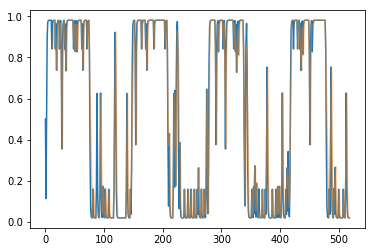

In [76]:
plt.plot(trial_df['Belief'])
plt.plot(feature_matrix[feature_matrix['Reward']==1]['Trial'], feature_matrix[feature_matrix['Reward']==1]['Belief'], alpha=0.5)
#plt.scatter(feature_matrix[feature_matrix['Reward']==1]['Trial'],temp[:,1,0], alpha=0.3)


#plt.scatter(temp[:,0,0], feature_matrix[feature_matrix['Reward']==1]['Belief'])
#temp = aligned_start.sum(axis=1)


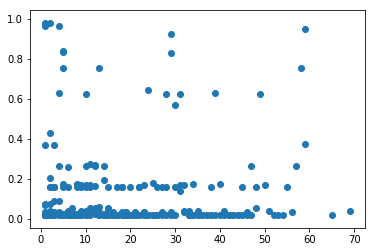

In [77]:
plt.scatter(feature_matrix[feature_matrix['Decision']==1]['Port Streak'],
            feature_matrix[feature_matrix['Decision']==1]['Belief'])

## function to get frames based on one to three conditions
    First define function so it can take multiple conditions:
    Input variables:
        df = feature matrix
        cond(n)_name = string containing column name (i.e. Reward, Switch) 
        cond(n) = desired identity (0,1)
        
    Output variables:
        frames = (num_Trials x 2) matrix containing frame # for center poke and decision poke for each trial


In [78]:
def extract_frames(df, cond1_name, cond1=False, cond2_name=False,cond2=False, cond3_name=False,
                   cond3=False, cond1_ops= '=', cond2_ops = '=', cond3_ops = '='):
    
    import operator
    
    # set up operator dictionary
    ops = {'>': operator.gt,
       '<': operator.lt,
       '>=': operator.ge,
       '<=': operator.le,
       '=': operator.eq}
    
    if type(cond3_name)==str:
        frames_c = (df[((ops[cond1_ops](df[cond1_name],cond1)) 
                    & (ops[cond2_ops](df[cond2_name], cond2))
                    & (ops[cond3_ops](df[cond3_name],cond3)))]['center_frame'])
        frames_d = (df[((ops[cond1_ops](df[cond1_name],cond1)) 
                    & (ops[cond2_ops](df[cond2_name], cond2))
                    & (ops[cond3_ops](df[cond3_name],cond3)))]['decision_frame'])
        frames = np.column_stack((frames_c, frames_d))
        return frames
    
    elif type(cond2_name)==str:
        frames_c = (df[((df[cond1_name] == cond1) 
                    & (df[cond2_name] == cond2))]['center_frame'])
        frames_d = (df[((df[cond1_name] == cond1) 
                    & (df[cond2_name] == cond2))]['decision_frame'])
        frames = np.column_stack((frames_c, frames_d))
        return frames
    
    else:
        frames_c =(df[(df[cond1_name] == cond1)]['center_frame'])
        frames_d =(df[(df[cond1_name] == cond1)]['decision_frame'])
        frames = np.column_stack((frames_c, frames_d))
        return frames

### Set the parameters to input into extract_frames function
    The notebook is set to automatically run for both conditions of each condition called.
    Setting n_variables to a value between 1 and 3 will run the corresponding number of conditions through the rest of the script.
    (This may be confusing because here you can always define up to 3 condition identities, but if n_variables is set to a value less than 3, only the first conditions will be included)

In [79]:
"""
Decision: 0=Right, 1=Left
Reward: 0=unrewarded, 1=rewarded
Switch: 0=last trial at same port, 1=last trial at different port-->switched
Belief: 0-1 value where 0 represents right port and 1 represents left port
"""

cond1_name = 'Switch'
cond1_a = 0
cond1_b = 1
cond1_ops = '='
cond2_name = 'Decision'
cond2_a = 0
cond2_b = 1
cond3_name = 'Reward'
cond3_a = 0
cond3_b = 1

conditions = [cond1_name, cond2_name, cond3_name]
n_variables = 2
extension = 30

cond1_ops_b='='
if cond1_ops != '=':
    if cond1_ops == '>':
        cond1_ops_b = '<='
        print(cond1_ops_b)
    elif cond1_ops == '>=':
        cond1_ops_b = '<'
        print(cond1_ops_b)

### Extract the frames for the specified conditions and create arrays containing frames for beginning and end of window of interest

    Set the value of 'extension' to the # of frames added before the center poke and after the decision poke
    fr_1x2x3x = center poke, decision poke frame #s for all trials with the corresponding conditions.

    At the moment this is not set up in the most efficient way...the extract_frames function operates by calling all 3 variables (i.e. Switch, Reward) across both conditions (a=0, b=1) to generate the maximum number of combinations (8 for 3 variables). If the number of variables is less than 3, it will later use the 'groupings_x' variables to concatenate these arrays into the appropriate final arrays (for example, to go from 3 variables to 2, all beginning with 1a2a get combined)

In [80]:
# center frames in first column, decision frames in second
fr_1a2a3a = extract_frames(feature_matrix, cond1_name, cond1_a, 
                           cond2_name, cond2_a, cond3_name, cond3_a, cond1_ops=cond1_ops)

fr_1b2a3a = extract_frames(feature_matrix, cond1_name, cond1_b, 
                           cond2_name, cond2_a, cond3_name, cond3_a, cond1_ops=cond1_ops_b)

fr_1a2b3a = extract_frames(feature_matrix, cond1_name, cond1_a, 
                           cond2_name, cond2_b, cond3_name, cond3_a, cond1_ops=cond1_ops)

fr_1b2b3a = extract_frames(feature_matrix, cond1_name, cond1_b, 
                           cond2_name, cond2_b, cond3_name, cond3_a, cond1_ops=cond1_ops_b)

fr_1a2b3b = extract_frames(feature_matrix, cond1_name, cond1_a, 
                           cond2_name, cond2_b, cond3_name, cond3_b, cond1_ops=cond1_ops)

fr_1a2a3b = extract_frames(feature_matrix, cond1_name, cond1_a, 
                           cond2_name, cond2_a, cond3_name, cond3_b, cond1_ops=cond1_ops)

fr_1b2a3b = extract_frames(feature_matrix, cond1_name, cond1_b, 
                           cond2_name, cond2_a, cond3_name, cond3_b, cond1_ops=cond1_ops_b)

fr_1b2b3b = extract_frames(feature_matrix, cond1_name, cond1_b, 
                           cond2_name, cond2_b, cond3_name, cond3_b, cond1_ops=cond1_ops_b)

var_keys = '1a2a3a', '1b2a3a', '1a2b3a', '1b2b3a', '1a2b3b', '1a2a3b', '1b2a3b', '1b2b3b'
groupings_2 = np.stack(((0,5), (1,6), (2,4), (3,7)))
groupings_1 = np.stack(((0,2,4,5), (1,3,6,7)))

#start_stop_frames = {var_keys[0]:fr_1a2a3a, var_keys[1]:fr_1b2a3a, var_keys[2]:fr_1a2b3a, var_keys[3]:fr_1b2b3a, 
#          var_keys[4]:fr_1a2b3b, var_keys[5]:fr_1a2a3b, var_keys[6]:fr_1b2a3b, var_keys[7]:fr_1b2b3b}


### Create a dictionary referencing every array of start/stop frames
    Start-stop_frames = frame starting however long the extension value was before the center poke frame, and frame that long after the decision poke
    Dictionary is designed to construct each array based on the number of variables (conditions) specified in the beginning...this is where the groupings variables are used to condense arrays for fewer conditions.

In [81]:
n_combos = 2**n_variables

for i in range(n_combos):
    if n_variables == 3:
        if i == 0:
            start_stop_frames = {var_keys[i]:eval('fr_%s' %var_keys[i])}
        if i > 0:
            start_stop_frames.update({var_keys[i]:eval('fr_%s' %var_keys[i])})
    if n_variables == 2:
        if i == 0:
            start_stop_frames = {var_keys[i][0:4]: np.transpose(np.column_stack((
                        np.transpose(eval('fr_%s' % var_keys[groupings_2[i][0]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_2[i][1]])))))}
        if i > 0:
            start_stop_frames.update({var_keys[i][0:4]: np.transpose(np.column_stack((
                        np.transpose(eval('fr_%s' % var_keys[groupings_2[i][0]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_2[i][1]])))))})
            if i == np.max(n_combos)-1:
                var_keys = list(start_stop_frames.keys())  

    if n_variables == 1:
        if i == 0:
            start_stop_frames = {var_keys[i][0:2]: np.transpose(np.column_stack((
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][0]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][1]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][2]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][3]])))))}
        if i > 0:
            start_stop_frames.update({var_keys[i][0:2]: np.transpose(np.column_stack((
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][0]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][1]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][2]])),
                        np.transpose(eval('fr_%s' % var_keys[groupings_1[i][3]])))))})
            if i == np.max(n_combos)-1:
                var_keys = list(start_stop_frames.keys())            

                
#if n_variables == 2:
#    var_keys = list(start_stop_frames.keys())     
        
start_stop_frames.keys()

dict_keys(['1b2a', '1b2b', '1a2a', '1a2b'])

In [82]:
for i in start_stop_frames:
    start_stop_frames[i][:,0] = start_stop_frames[i][:,0] - extension
    start_stop_frames[i][:,1] = start_stop_frames[i][:,1] + extension

### Set up some other parameters to be used in the rest of the script
    detectEvents() returns binary matrix of 0s and 1s representing frames where events occurred. Replace raw trace file with this processed file and apply a Gaussian filter over events.
    
    --nNeurons = number of neurons output by CNMF-e
        Redefined as number of neurons after some initial processing:

    Working on a function to combine the above with previous execution of this script on the raw trace file using a flag for 'events'. Once that's complete, will need to add back in NaN cleansing (this is already incorporated into the detectEvents() function). The following arrays will then be used.
    
    --nan_neurons = any neurons containing NaNs in their calcium traces
    --good_neurons = neurons not containing NaNs -- used to redefine nNeurons

In [83]:
events = cc.detectEvents(ca_data_path)

neuron.C_raw = np.copy(events)
nNeurons = neuron.C_raw.shape[0]
nFrames = neuron.C_raw.shape[1]

#Create Gaussian filter and apply to raw trace
sigma = 3;
sz = 10; # total width 

x = np.linspace(-sz / 2, sz / 2, sz);
gaussFilter = np.exp(-x**2 / (2*sigma**2));
gaussFilter = gaussFilter / np.sum(gaussFilter);

smoothed = np.zeros((nNeurons, neuron.C_raw.shape[1]+sz-1));

for i in range(0, nNeurons):
    smoothed[i,:] = np.convolve(neuron.C_raw[i,:], gaussFilter);
    
neuron.C_raw = smoothed[:,0:nFrames]

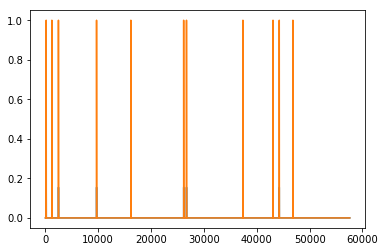

In [84]:
# This is just used to visualize the effect of the Gaussian filter on each event
plt.plot(neuron.C_raw[0,:])
plt.plot(events[0,:])

### Calculate the number of frames required to span the longest trial in all conditions, and use this for all trials
    --nTrials = list of number of trials in each condition (length = n_combos)

    --max_window = find window length (number of frames) required to capture center poke to decision poke for all trials (with extensions) and then just take maximum length trial across all conditions)

In [85]:
nTrials = [start_stop_frames[var_keys[i]].shape[0] for i in range(n_combos)]
max_window = np.zeros(n_combos) 
window_length= np.zeros((np.max(nTrials), n_combos))

    
for i in range(n_combos):
    for iTrial in range(nTrials[i]):
        window_length[iTrial, i] = int(((start_stop_frames[var_keys[i]][iTrial][1]-
                                 start_stop_frames[var_keys[i]][iTrial][0])))
    max_window[i] = np.max(window_length)
    
max_window = int(max_window.max())

In [86]:
med_trial_length = [np.median(window_length[0:nTrials[i],:]) for i in range(n_combos)]
med_trial_length = np.median(med_trial_length) - 2*extension

### Aligned to center poke
    Pull out segements of calcium traces in designated window of frames. Calculate mean fluorescence for each neuron across all trials. 
    -- aligned_start = (number of trials x number frames x number of neurons x number of combinations)
    -- mean_center_poke = mean fluorescence (or mean number of events) for each neuron across all trials aligned to center poke
    
    If using raw traces, will add back in normalization here.


In [87]:
print(int(start_stop_frames[var_keys[i]][iTrial][0]))
start_stop_frames[var_keys[i]][iTrial][0]+max_window


57296


57408.0

In [88]:
aligned_start = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))
mean_center_poke = np.zeros((max_window, nNeurons, n_combos))
during_trial = np.zeros_like((aligned_start))

for i in range(n_combos):

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to center poke
    for iNeuron in range(nNeurons): # for each neuron
        for iTrial in range(0,nTrials[i]): # and for each trial
            aligned_start[iTrial,:, iNeuron, i] = neuron.C_raw[iNeuron,
                int(start_stop_frames[var_keys[i]][iTrial][0]):
                (int(start_stop_frames[var_keys[i]][iTrial][0])+max_window)]
            during_trial[iTrial,0:int(window_length[iTrial,i]-extension),iNeuron,i] = neuron.C_raw[iNeuron,
                int(start_stop_frames[var_keys[i]][iTrial][0]+extension):
                (int(start_stop_frames[var_keys[i]][iTrial][0] +window_length[iTrial,i]))]
  
    # take mean of fluorescent traces across all trials for each neuron, then normalize
    # for each neuron
    mean_center_poke[:,:,i]= np.mean(aligned_start[0:nTrials[i],:,:,i], axis=0)


In [89]:
pre_trial = aligned_start[:, int(extension-med_trial_length):extension, :, :].sum(axis=1)
during_trial = during_trial.sum(axis=1)

(array([  8.,  26.,  14.,  10.,   5.,   3.,   1.,   2.,   0.,   2.]),
 array([ 0.03125,  0.3625 ,  0.69375,  1.025  ,  1.35625,  1.6875 ,
         2.01875,  2.35   ,  2.68125,  3.0125 ,  3.34375]),
 <a list of 10 Patch objects>)

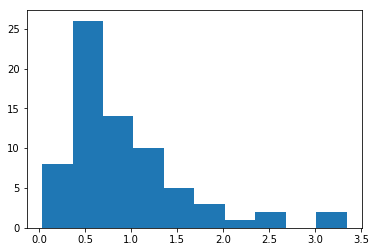

In [90]:
plt.hist(neuron.C_raw.sum(axis=1)/32)

### Plot heatmap of average events per trial (intensity) for each neuron (y) over time (x)
### Aligned to center poke

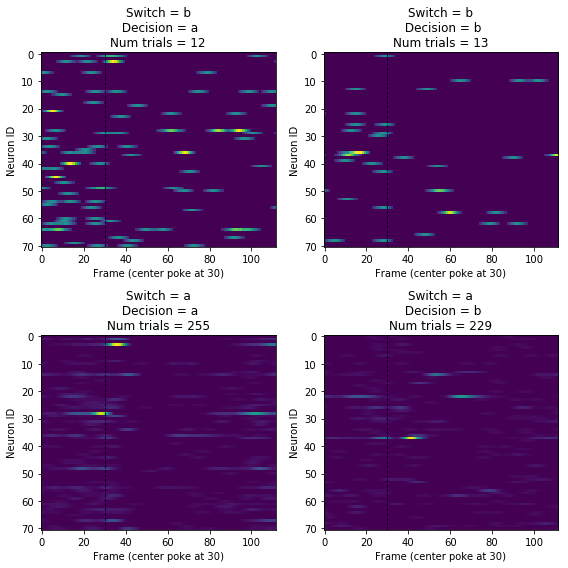

In [91]:
ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_center_poke[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[int(var_keys[i][0])-1], var_keys[i][1],
                    conditions[int(var_keys[i][2])-1], var_keys[i][3], 
                    conditions[int(var_keys[i][4])-1],
                    var_keys[i][5], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[int(var_keys[i][0])-1], var_keys[i][1],
                    conditions[int(var_keys[i][2])-1], var_keys[i][3], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[int(var_keys[i][0])-1], var_keys[i][1], nTrials[i]))
plt.tight_layout()

### heatmap for calcium traces of a single neuron across all trials
    white dashed line for center poke time
    white vertical lines for decision poke time -- need something more subtle

(-0.5, 111.5, 11.5, -0.5)

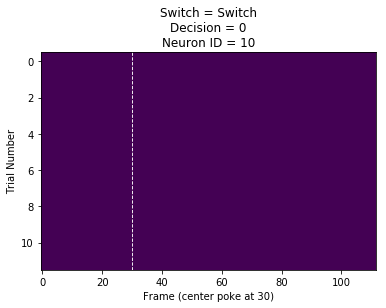

In [92]:
sample_neuron = 10

#plt.figure(figsize=(10,10))
plt.imshow(aligned_start[0:nTrials[0],:,sample_neuron, 0])
plt.axvline(x=extension, color='white', linestyle = '--', linewidth=.9)
plt.ylabel('Trial Number')
plt.xlabel('Frame (center poke at %s)' %extension)
#plt.scatter((start_stop_times[var_keys[0][:]])-(start_stop_frames[var_keys[0]])+extension,range(nTrials[0]), color='white', marker = '|', s=10)
plt.title('%s = %s\n%s = %s\nNeuron ID = %s' % (cond1_name, conditions[0], cond2_name, cond2_a, sample_neuron))
plt.axis('tight')


## aligned to decision poke
    Same process as for aligned to center poke

In [93]:
aligned_decision = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))
mean_decision = np.zeros((max_window, nNeurons, n_combos))

for i in range(n_combos):

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to decision poke
    for iNeuron in range(nNeurons):
        for iTrial in range(nTrials[i]):
            aligned_decision[iTrial,:, iNeuron, i] = neuron.C_raw[iNeuron, 
                int(start_stop_frames[var_keys[i]][iTrial][1])-max_window:
                (int(start_stop_frames[var_keys[i]][iTrial][1]))]

    # take mean of fluorescent traces across all trials for each neuron
    mean_decision[:,:,i]= np.mean(aligned_decision[0:nTrials[i],:,:,i], axis=0)
   

In [94]:
post_trial = aligned_decision[:, int(max_window-extension):int(max_window-extension + 
             med_trial_length), :, :].sum(axis=1)

c


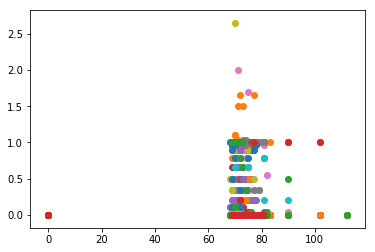

In [95]:
[plt.scatter(window_length[:,c], during_trial[:,n,c]) for n in range(nNeurons) 
 for c in range(n_combos)]
print('c')

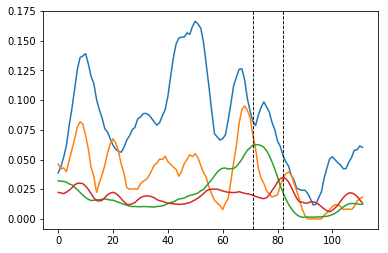

In [96]:
temp = mean_decision.sum(axis=1)
[plt.plot(np.transpose(temp[:,c])) for c in range(n_combos)]
plt.axvline(x=max_window-extension, linestyle='--', color='k', linewidth=.9)
plt.axvline(x=max_window-(med_trial_length+extension), linestyle='--', color='k', linewidth=.9)

### Plot heatmap aligned to decision poke

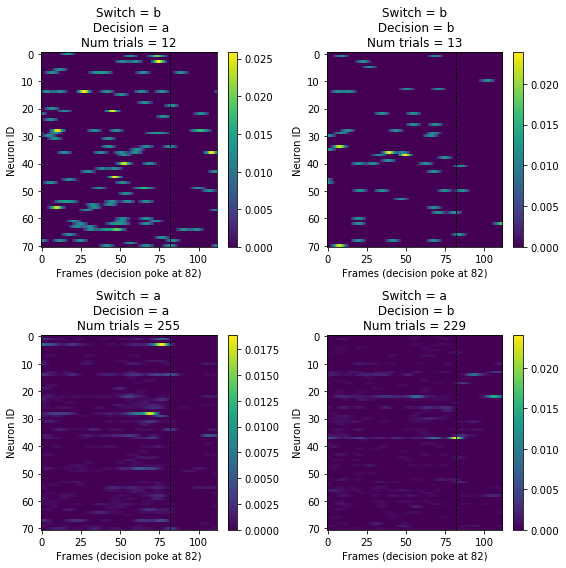

In [97]:
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):
    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_decision[:,:,i])), plt.colorbar()
    plt.axvline(x=max_window-extension, color='k', linestyle = '--', linewidth=.9)
    plt.xlabel('Frames (decision poke at %s)' % (max_window-extension))
    plt.ylabel('Neuron ID')
    plt.axis('tight')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[int(var_keys[i][0])-1], var_keys[i][1],
                    conditions[int(var_keys[i][2])-1], var_keys[i][3], 
                    conditions[int(var_keys[i][4])-1],
                    var_keys[i][5], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[int(var_keys[i][0])-1], var_keys[i][1],
                    conditions[int(var_keys[i][2])-1], var_keys[i][3], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[int(var_keys[i][0])-1], var_keys[i][1], nTrials[i]))
plt.tight_layout()